In [120]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tqdm.auto import tqdm
from nltk import tokenize

tqdm.pandas()

In [4]:
ALLEN_AI_SUBS_PATH = "../res/allenai/metadata_subset.csv"

In [5]:
df_allen = pd.read_csv(ALLEN_AI_SUBS_PATH)[['source_x', 'title', 'abstract', 'publish_time', 'journal', 'is_pr']]
df_allen = df_allen.fillna('')

print(len(df_allen.index))
df_allen.head(5)

58007


,source_x,title,abstract,publish_time,journal,is_pr
0,PMC,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,The EMBO Journal,True
1,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,The EMBO Journal,True
2,PMC,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,EMBO J,True
3,PMC,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,The EMBO Journal,True
4,PMC,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,The EMBO Journal,True


In [6]:
raw_txt = df_allen[['title', 'abstract']].agg(' - '.join, axis=1)
raw_txt.values[:2]

array(['Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis - Nidovirus subgenomic mRNAs contain a leader sequence derived from the 5′ end of the genome fused to different sequences (‘bodies’) derived from the 3′ end. Their generation involves a unique mechanism of discontinuous subgenomic RNA synthesis that resembles copy-choice RNA recombination. During this process, the nascent RNA strand is transferred from one site in the template to another, during either plus or minus strand synthesis, to yield subgenomic RNA molecules. Central to this process are transcription-regulating sequences (TRSs), which are present at both template sites and ensure the fidelity of strand transfer. Here we present results of a comprehensive co-variation mutagenesis study of equine arteritis virus TRSs, demonstrating that discontinuous RNA synthesis depends not only on base pairing between sense leader TRS and antisense body TRS, but also on the primary se

In [114]:
sid = SentimentIntensityAnalyzer()
col_names = [x + '_' + y for x in ['mean', 'max'] for y in ['compound', 'neg', 'neu', 'pos', 'agg']]
def get_sent_stats(text):
    lines_list = tokenize.sent_tokenize(text)
    stats_by_sent = [sid.polarity_scores(line) for line in lines_list]
    df_stats = pd.DataFrame(stats_by_sent)
    df_agg = df_stats.agg(['mean', 'max'])
    df_agg['agg'] = df_agg['pos'] - df_agg['neg']
    return pd.Series(df_agg.values.flatten())

In [117]:
scores = raw_txt.progress_apply(get_sent_stats)
df_sent_scores = pd.DataFrame(scores)
df_sent_scores.columns=col_names
df_sent_scores.head()

,mean_compound,mean_neg,mean_neu,mean_pos,mean_agg,max_compound,max_neg,max_neu,max_pos,max_agg
0,0.147571,0.00000,0.949286,0.050714,0.050714,0.3818,0.000,1.0,0.111,0.111
1,0.037717,0.00000,0.987333,0.012667,0.012667,0.2263,0.000,1.0,0.076,0.076
2,0.245529,0.00000,0.923571,0.076429,0.076429,0.5023,0.000,1.0,0.163,0.163
3,0.034250,0.00725,0.972625,0.020125,0.012875,0.6124,0.058,1.0,0.161,0.103
4,0.123850,0.02230,0.926500,0.051200,0.028900,0.6369,0.223,1.0,0.160,-0.063


In [144]:
df_sent_scores.describe()

,mean_compound,mean_neg,mean_neu,mean_pos,mean_agg,max_compound,max_neg,max_neu,max_pos,max_agg
count,58007.000000,58007.000000,58007.000000,58007.000000,58007.000000,58007.000000,58007.000000,58007.000000,58007.000000,58007.000000
mean,0.034099,0.046054,0.891452,0.055883,0.009829,0.405341,0.137129,0.973701,0.157939,0.020810
std,0.202444,0.060751,0.096050,0.056507,0.084936,0.318283,0.113653,0.080515,0.110426,0.140746
min,-0.974900,0.000000,0.000000,0.000000,-1.000000,-0.974900,0.000000,0.000000,0.000000,-1.000000
25%,-0.054900,0.006214,0.861200,0.017889,-0.015667,0.153100,0.047000,1.000000,0.085000,-0.047000
50%,0.013933,0.030667,0.905800,0.046571,0.005143,0.458800,0.130000,1.000000,0.158000,0.005000
75%,0.143537,0.062333,0.945889,0.077750,0.044250,0.652300,0.204000,1.000000,0.226000,0.103000
max,0.971900,1.000000,1.000000,0.831000,0.831000,0.992100,1.000000,1.000000,1.000000,1.000000


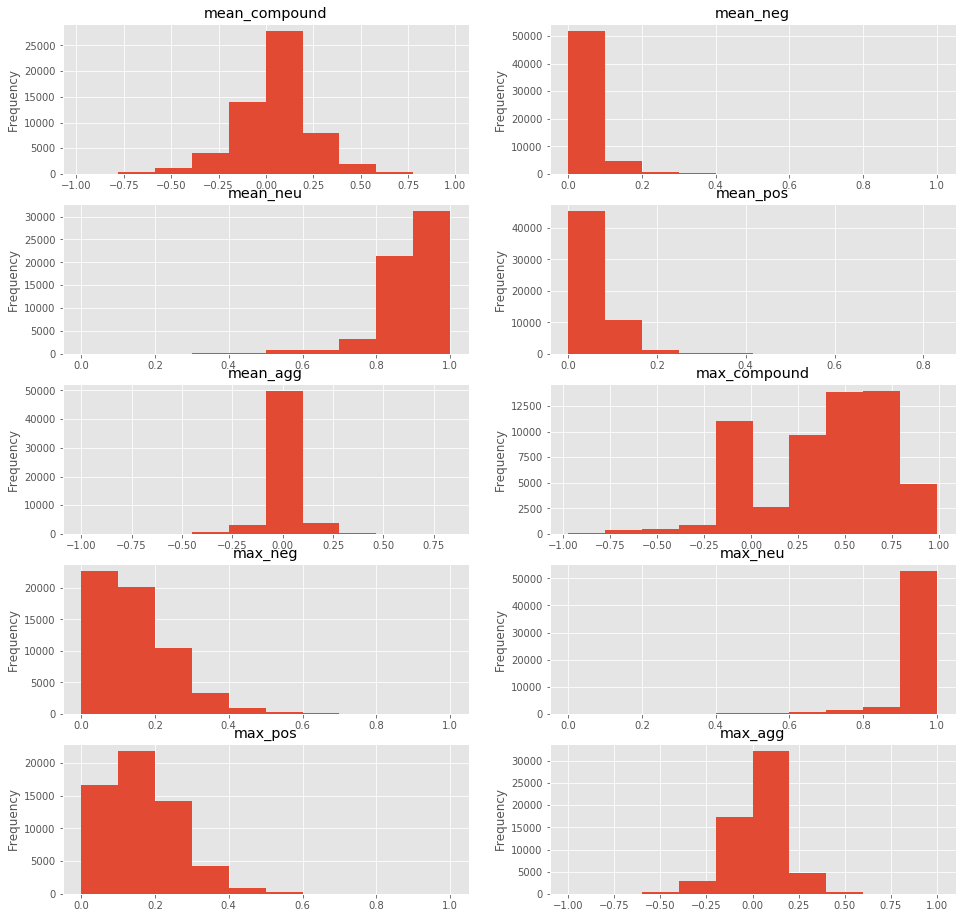

In [122]:
fig = plt.figure(figsize=(16,16))
for i, col in enumerate(col_names):
    ax = fig.add_subplot(math.ceil(len(col_names)/2),2,i+1)
    df_sent_scores[col].plot(kind='hist', title=col, ax=ax)

In [132]:
df_sent_an = pd.concat([df_allen, df_sent_scores], axis=1)
df_sent_an.head()

,source_x,title,abstract,publish_time,journal,is_pr,mean_compound,mean_neg,mean_neu,mean_pos,mean_agg,max_compound,max_neg,max_neu,max_pos,max_agg
0,PMC,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,The EMBO Journal,True,0.147571,0.00000,0.949286,0.050714,0.050714,0.3818,0.000,1.0,0.111,0.111
1,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,The EMBO Journal,True,0.037717,0.00000,0.987333,0.012667,0.012667,0.2263,0.000,1.0,0.076,0.076
2,PMC,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,EMBO J,True,0.245529,0.00000,0.923571,0.076429,0.076429,0.5023,0.000,1.0,0.163,0.163
3,PMC,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,The EMBO Journal,True,0.034250,0.00725,0.972625,0.020125,0.012875,0.6124,0.058,1.0,0.161,0.103
4,PMC,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,The EMBO Journal,True,0.123850,0.02230,0.926500,0.051200,0.028900,0.6369,0.223,1.0,0.160,-0.063


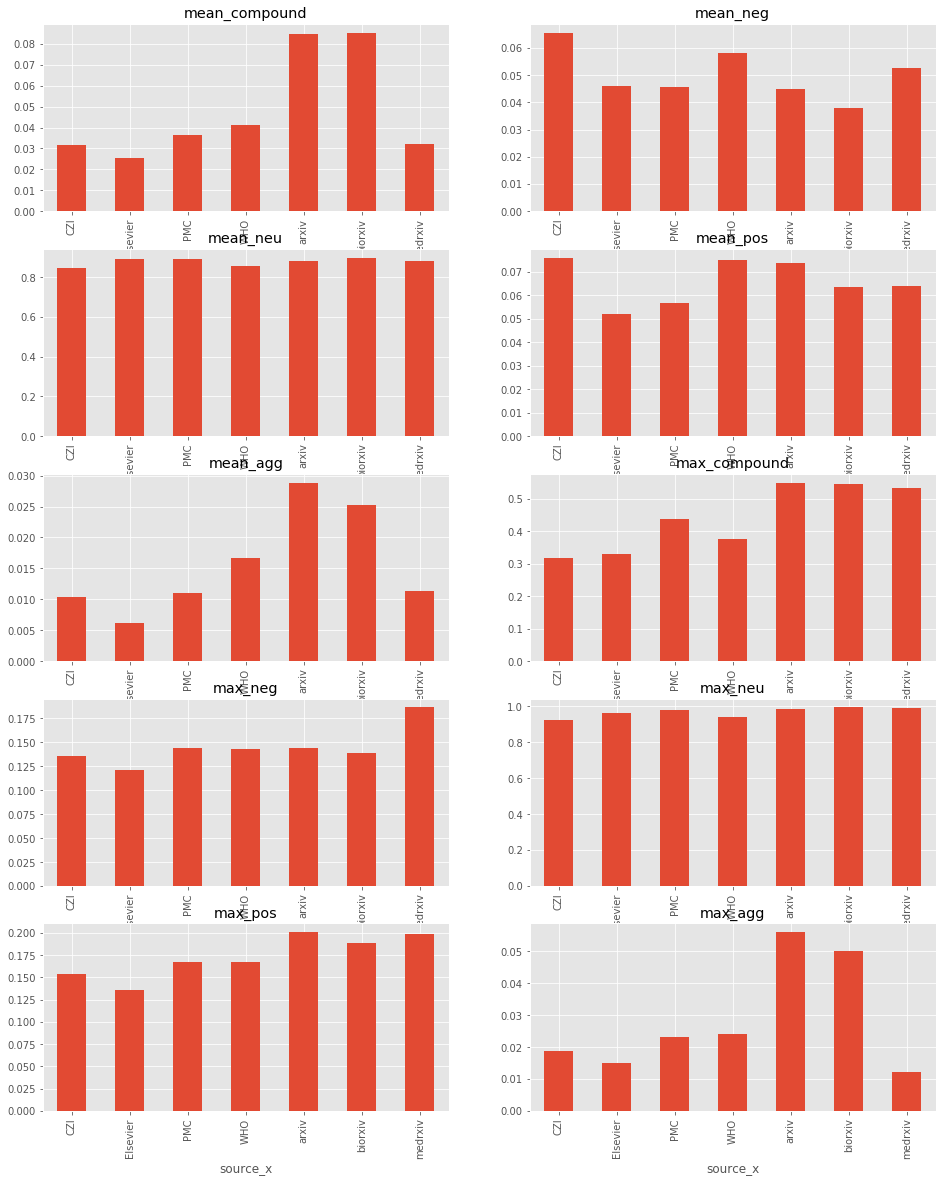

In [140]:
fig = plt.figure(figsize=(16,20))
for i, col in enumerate(col_names):
    ax = fig.add_subplot(math.ceil(len(col_names)/2),2,i+1)
    df_sent_an.groupby('source_x')[col].mean().plot(kind='bar', title=col, ax=ax)

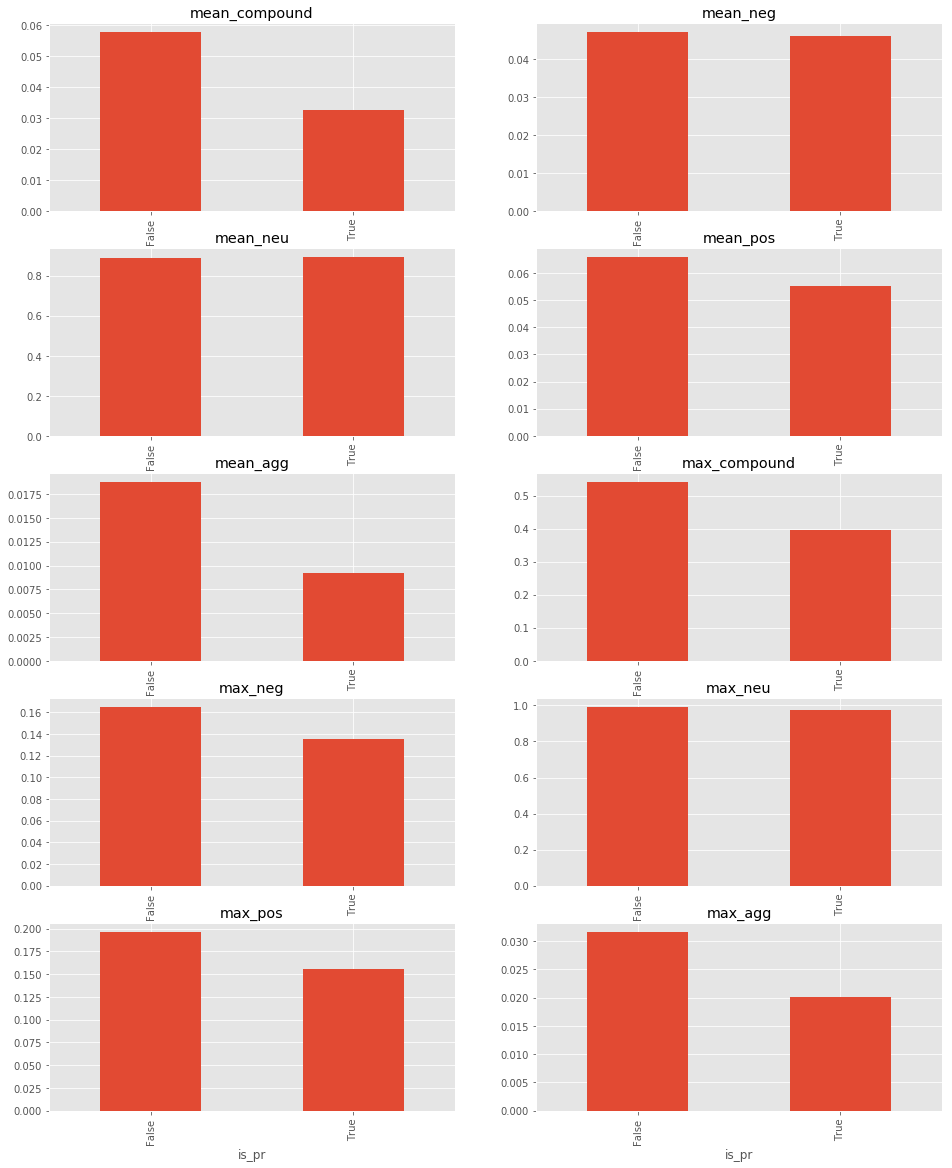

In [141]:
fig = plt.figure(figsize=(16,20))
for i, col in enumerate(col_names):
    ax = fig.add_subplot(math.ceil(len(col_names)/2),2,i+1)
    df_sent_an.groupby('is_pr')[col].mean().plot(kind='bar', title=col, ax=ax)

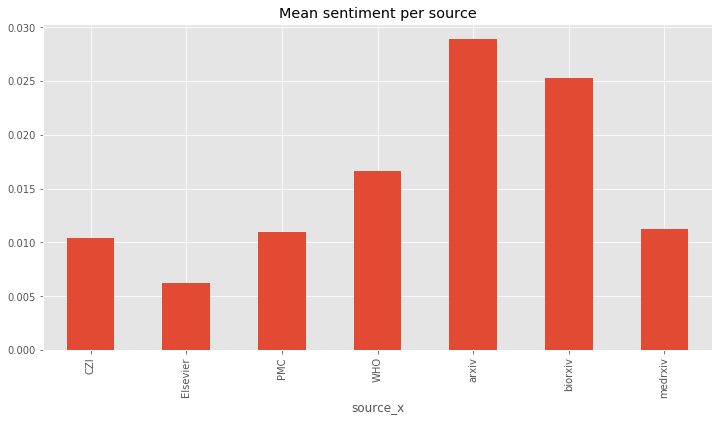

In [143]:
df_sent_an.groupby('source_x')['mean_agg'].mean().plot(kind='bar', title='Mean sentiment per source', figsize=(12,6))